In [1]:
from accelerate import Accelerator
from datasets import Dataset, DatasetDict
import csv
import evaluate
#from huggingface_hub import Repository, get_full_repo_name, create_repo
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import AutoModelForTokenClassification
from transformers import AutoTokenizer
from transformers import DataCollatorForTokenClassification
from transformers import get_scheduler
from transformers import TrainingArguments
from transformers import Trainer
from tqdm.auto import tqdm


2024-11-09 17:27:54.066216: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-09 17:27:54.073861: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731169674.082367 2687818 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731169674.085078 2687818 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-09 17:27:54.094255: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:

import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available:", len(gpus))

if gpus:
    try:
        # Enable memory growth for each GPU to prevent TensorFlow from allocating all GPU memory at once
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print("Error setting memory growth:", e)
else:
    print("No GPU detected. Using CPU.")



Num GPUs Available: 1
1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1731169686.600718 2687818 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6223 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


## Helper functions and declarations

In [59]:
label_names = ['O', 'B-ART','I-ART','B-CON','I-CON','B-LOC','I-LOC',
        'B-MAT','I-MAT','B-PER','I-PER','B-SPE','I-SPE']
id2label = {i: l for i, l in enumerate(label_names)}
label2id = {l: i for i, l in id2label.items()}

model_name = "bert-finetuned-archeology"
base_model_checkpoint = "bert-base-cased"

In [60]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels


def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples['tokens'], truncation=True, is_split_into_words=True
    )
    all_labels = examples['ner_tags']
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))
    
    tokenized_inputs['labels'] = new_labels
    return tokenized_inputs


def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }


def parse(sentence):
    tokens, ner_tags = [], []
    for phrase in sentence:
            features = phrase.split(' ')
            tokens.append(features[0].strip())
            ner_tags.append(label2id[features[2].strip()])
    return {'tokens': tokens, 'ner_tags': ner_tags}


def postprocess(predictions, labels):
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_labels, true_predictions

## Data Loading

In [61]:
raw_datasets = {}
for split in ('train', 'val', 'test'):
    raw_datasets[split] = {}
    with open(f'{split}.txt', 'r') as infile:
        raw_data = infile.read()
        lines = raw_data.split('\n')
        sentences = raw_data.split('\n\n')
        sentences = [parse(sentence.split('\n')) for sentence in sentences]
        for sentence in sentences:
            for k in sentence:
                if k not in raw_datasets[split].keys():
                    raw_datasets[split][k] = []
                raw_datasets[split][k].append(sentence[k])


datasets = {}
for split in raw_datasets.keys():
    datasets[split] = Dataset.from_dict(raw_datasets[split])
data = DatasetDict(datasets)

### Data statistics

#### NER label distribution

In [20]:
ner = data['train']['ner_tags']
ner += data['test']['ner_tags']
ner += data['val']['ner_tags']
ner = np.array([tag for taglist in ner for tag in taglist])

In [21]:
ner_df = pd.DataFrame(ner, columns=['ner_tag'])
ner_df['ner_label'] = ner_df['ner_tag'].map(id2label)
ner_df.loc[ner_df['ner_label'] != 'O','ner_label_grouped'] = \
    ner_df.loc[ner_df['ner_label'] != 'O','ner_label'].apply(
        lambda x: x.split('-')[1])
ner_df['ner_label_grouped'] = ner_df['ner_label_grouped'].fillna('O')
ner_df_counts = ner_df.groupby(
    ['ner_label_grouped', 'ner_label']
)['ner_label'].count().to_frame().drop('O')
ner_df_counts.columns = ['counts']

In [22]:
ner_distribution = ner_df.groupby(['ner_label_grouped', 'ner_label'])['ner_label'].count().to_frame()
ner_distribution.columns = ['counts']
ner_distribution = ner_distribution.reset_index()

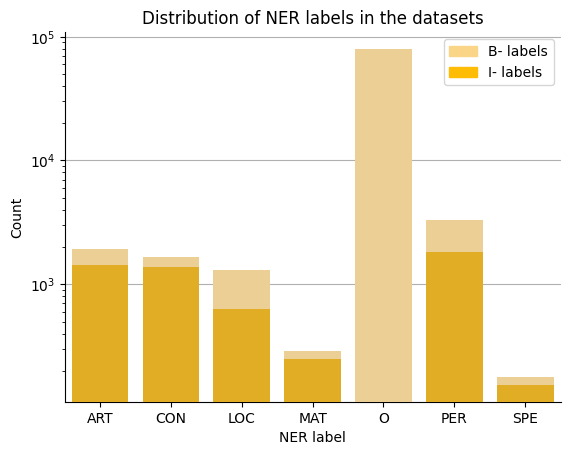

In [23]:
bottom_df = ner_distribution.loc[ner_distribution['ner_label'].str.startswith('B')]

fig, ax = plt.subplots()
ax.grid(axis='y', zorder=2)
sns.barplot(data=ner_distribution, x='ner_label_grouped', y='counts',
            estimator=sum, ax=ax, color='#fad487', errorbar=None, zorder=3)
sns.barplot(data=bottom_df, x='ner_label_grouped', y='counts', ax=ax,
            color='#ffbc05', zorder=3)
top_bar = mpatches.Patch(color='#fad487', label='B- labels')
bottom_bar = mpatches.Patch(color='#ffbc05', label='I- labels')
plt.legend(handles=[top_bar, bottom_bar])
ax.set_yscale('log')
sns.despine()
ax.set(title='Distribution of NER labels in the datasets',
       xlabel='NER label', ylabel='Count')
plt.show()

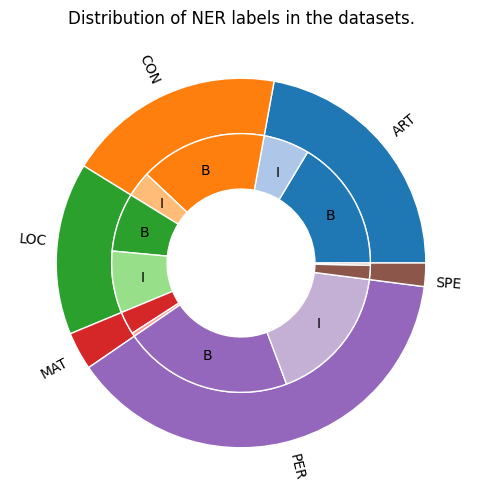

In [24]:
fig, ax = plt.subplots(figsize=(6, 6))
cmap = plt.colormaps["tab20"]
size=0.3
outer_colors = cmap(np.arange(6)*2)
inner_colors = cmap(np.arange(12))
textprops = {'color': 'k'}
startangle = 0

outer_labels = ner_df_counts.index.get_level_values(0).drop_duplicates()
wedges, texts = ax.pie(
    ner_df_counts.groupby(level=[0]).sum().values.flatten(),
    labels=outer_labels,
    radius=1, colors=outer_colors,
    wedgeprops=dict(width=size, edgecolor='w'),
    labeldistance=1.05,
    rotatelabels=True,
    textprops=textprops,
    startangle=startangle)

inner_labels = [i.split('-')[0] 
                for i in ner_df_counts.index.get_level_values(1).to_list()]

inner_labels[-2:] = [''] * 2
inner_labels[6:8] = [''] * 2
ax.pie(ner_df_counts.values.flatten(),
       labels=inner_labels,
       radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'),
       labeldistance=0.75,
       textprops=textprops,
       startangle=startangle)

ax.set_title('Distribution of NER labels in the datasets.')
plt.show()

## Preprocessing

In [62]:
tokenizer = AutoTokenizer.from_pretrained(base_model_checkpoint)

data_tokenized = data.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=data['train'].column_names)

Map:   0%|          | 0/1992 [00:00<?, ? examples/s]

Map:   0%|          | 0/850 [00:00<?, ? examples/s]

Map:   0%|          | 0/864 [00:00<?, ? examples/s]

## Training - Fine tunning with default hyperparameters

### Training set-up

In [63]:
data_collator = DataCollatorForTokenClassification(tokenizer)
metric = evaluate.load('seqeval')

model = AutoModelForTokenClassification.from_pretrained(
    base_model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

args = TrainingArguments(
    model_name,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    #push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=data_tokenized["train"],
    eval_dataset=data_tokenized["val"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training loop

In [64]:
trainer.train()
#trainer.push_to_hub(commit_message="Training complete") 

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.213042,0.467464,0.643004,0.541360,0.942698
2,No log,0.212484,0.529215,0.652263,0.584332,0.948803
3,0.188400,0.224858,0.504580,0.680041,0.579316,0.946492


/vol/home/s4422090/.local/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=747, training_loss=0.14538072869480853, metrics={'train_runtime': 113.5937, 'train_samples_per_second': 52.609, 'train_steps_per_second': 6.576, 'total_flos': 200646868443840.0, 'train_loss': 0.14538072869480853, 'epoch': 3.0})

## Evaluate on test set

In [55]:
# Evaluate on the test set
test_results = trainer.predict(data_tokenized["test"])
test_predictions, test_labels, _ = test_results

test_predictions = np.argmax(test_predictions, axis=2)

true_test_predictions = [
    [id2label[pred] for (pred, lab) in zip(prediction, label) if lab != -100]
    for prediction, label in zip(test_predictions, test_labels)
]
true_test_labels = [
    [id2label[lab] for (pred, lab) in zip(prediction, label) if lab != -100]
    for label, prediction in zip(test_labels, test_predictions)
]

results = metric.compute(predictions=true_test_predictions, references=true_test_labels)

precision = results["overall_precision"]
recall = results["overall_recall"]
f1 = results["overall_f1"]

print(f"Precision on Test Set: {precision:.4f}")
print(f"Recall on Test Set: {recall:.4f}")
print(f"F1 Score on Test Set: {f1:.4f}")

Precision on Test Set: 0.5971
Recall on Test Set: 0.7198
F1 Score on Test Set: 0.6527


## Hyperparameter optimization

Plan for hyperparameter optimization (grid search approach):

1. `learning_rate`: `[2e-5, 1e-4, 1e-2]`
1. `weight_decay`: `[0.0, 0.1, 0.01]`
1. `batch_size`: `[8, 16]`
1. `warm_up`: `[0,100,500]`


In [ ]:
model_checkpoint = 'bert-base-cased'
num_train_epochs = 3


In [14]:
params_list = [{'lr': lr, 'wd': wd, 'batch_size': batch_size, 'warm_up': warm_up}
               for lr in (2e-5, 1e-4, 1e-2)
               for wd in (0.0, 0.1, 0.01)
               for batch_size in (16, 8)
               for warm_up in (0, 100, 500)]

In [10]:
data_collator = DataCollatorForTokenClassification(tokenizer)
best_model_dir = 'bert-finetuned-archeology-optimized'
#repo_name = get_full_repo_name(best_model_dir)
#repo = Repository(best_model_dir, clone_from=repo_name)
#repo_name

In [15]:
import gc


total_configs = len(params_list)
print(f"Total Hyperparameter Configurations to Test: {total_configs}\n")

all_results = {}
best_f1 = 0.0
best_model = None

"""
# Uncomment if run out of memory and don't want to restart the kernel

del model, optimizer, train_dataloader, eval_dataloader
torch.cuda.empty_cache()
gc.collect()
"""

for i, params in enumerate(params_list):
    run_id = '[lr={}; wd={}; batch_size={}; warm_up={}]'.format(
        params['lr'], params['wd'], params['batch_size'], params['warm_up']
    )
    all_results[run_id] = {}
    print(f"Running configuration {i + 1} / {total_configs}: {run_id}")
    num_training_steps = num_train_epochs * len(data_tokenized['train']) // params['batch_size']
    progress_bar = tqdm(range(num_training_steps))
    metric = evaluate.load('seqeval')
    model = AutoModelForTokenClassification.from_pretrained(
        model_checkpoint, id2label=id2label, label2id=label2id
    )
    optimizer = AdamW(model.parameters(), 
                      lr=params['lr'],
                      weight_decay=params['wd'])

    train_dataloader = DataLoader(
        data_tokenized['train'],
        shuffle=True,
        collate_fn=data_collator,
        batch_size=params['batch_size'],
    )

    eval_dataloader = DataLoader(
        data_tokenized['val'],
        collate_fn=data_collator,
        batch_size=params['batch_size'],
    )

    accelerator = Accelerator() # smaller precision to avoid memory issues
    model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
        model, optimizer, train_dataloader, eval_dataloader
    )

    num_update_steps_per_epoch = len(train_dataloader)
    num_training_steps = num_train_epochs * num_update_steps_per_epoch

    lr_scheduler = get_scheduler(
        'linear',
        optimizer=optimizer,
        num_warmup_steps=params['warm_up'],
        num_training_steps=num_training_steps
    )
    for epoch in range(num_train_epochs):
        model.train()
        for batch in train_dataloader:
            gc.collect() 
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)

        model.eval()
        for batch in eval_dataloader:
            with torch.no_grad():
                outputs = model(**batch)
            
            predictions = outputs.logits.argmax(dim=-1)
            labels = batch['labels']
            predictions_padded = accelerator.pad_across_processes(predictions, 
                                                                dim=1, 
                                                                pad_index=-100)
            labels_padded = accelerator.pad_across_processes(labels, 
                                                            dim=1, 
                                                            pad_index=-100)
            predictions_gathered = accelerator.gather(predictions_padded)
            labels_gathered = accelerator.gather(labels_padded)

            true_predictions, true_labels = postprocess(predictions_gathered,
                                                        labels_gathered)

            metric.add_batch(predictions=true_predictions, references=true_labels)
            
        all_results[run_id][epoch] = metric.compute()
        print(
            f"epoch {epoch}:",
            {
                key: all_results[run_id][epoch][f"overall_{key}"]
                for key in ["precision", "recall", "f1", "accuracy"]
            },
        )
        accelerator.wait_for_everyone()
        if all_results[run_id][epoch]['overall_f1'] > best_f1:
            best_f1 = all_results[run_id][epoch]['overall_f1']
            unwrapped_model = accelerator.unwrap_model(model)
            best_model = unwrapped_model
    
    # Clean up memory so it does not build up
    del model, optimizer, train_dataloader, eval_dataloader
    torch.cuda.empty_cache()
    gc.collect()
            

best_model.save_pretrained(best_model_dir, save_function=accelerator.save)
if accelerator.is_main_process:
    tokenizer.save_pretrained(best_model_dir)
    #repo.push_to_hub(commit_message=f"Best optimized model", blocking=False)

Total Hyperparameter Configurations to Test: 54

Running configuration 1 / 54: [lr=2e-05; wd=0.0; batch_size=16; warm_up=0]


  0%|          | 0/373 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/home/s4422090/.local/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 0: {'precision': np.float64(0.5648148148148148), 'recall': np.float64(0.34746835443037977), 'f1': np.float64(0.43025078369905956), 'accuracy': 0.927041995551873}
epoch 1: {'precision': np.float64(0.6039094650205762), 'recall': np.float64(0.48075348075348073), 'f1': np.float64(0.5353397172822618), 'accuracy': 0.942959312720771}
epoch 2: {'precision': np.float64(0.6481481481481481), 'recall': np.float64(0.4656319290465632), 'f1': np.float64(0.5419354838709677), 'accuracy': 0.9424796127512973}
Running configuration 2 / 54: [lr=2e-05; wd=0.0; batch_size=16; warm_up=100]


  0%|          | 0/373 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.27469135802469136), 'recall': np.float64(0.38197424892703863), 'f1': np.float64(0.3195691202872531), 'accuracy': 0.92569011381972}
epoch 1: {'precision': np.float64(0.6008230452674898), 'recall': np.float64(0.43745318352059925), 'f1': np.float64(0.506285218899003), 'accuracy': 0.9368104312938816}
epoch 2: {'precision': np.float64(0.6707818930041153), 'recall': np.float64(0.4607773851590106), 'f1': np.float64(0.5462924172601592), 'accuracy': 0.939078103876848}
Running configuration 3 / 54: [lr=2e-05; wd=0.0; batch_size=16; warm_up=500]


  0%|          | 0/373 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9028825607256552}
epoch 1: {'precision': np.float64(0.2962962962962963), 'recall': np.float64(0.3333333333333333), 'f1': np.float64(0.3137254901960785), 'accuracy': 0.9226374776503423}
epoch 2: {'precision': np.float64(0.6100823045267489), 'recall': np.float64(0.39038841342988806), 'f1': np.float64(0.47611401043757523), 'accuracy': 0.9299638044568488}
Running configuration 4 / 54: [lr=2e-05; wd=0.0; batch_size=8; warm_up=0]


  0%|          | 0/747 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.6347736625514403), 'recall': np.float64(0.4474256707759246), 'f1': np.float64(0.5248830284985112), 'accuracy': 0.9399502856395273}
epoch 1: {'precision': np.float64(0.6666666666666666), 'recall': np.float64(0.5264012997562957), 'f1': np.float64(0.5882886972310486), 'accuracy': 0.9493698486764641}
epoch 2: {'precision': np.float64(0.6779835390946503), 'recall': np.float64(0.4936329588014981), 'f1': np.float64(0.5713047247507586), 'accuracy': 0.9453142034800053}
Running configuration 5 / 54: [lr=2e-05; wd=0.0; batch_size=8; warm_up=100]


  0%|          | 0/747 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.6172839506172839), 'recall': np.float64(0.4618937644341801), 'f1': np.float64(0.5284015852047556), 'accuracy': 0.9408660764903406}
epoch 1: {'precision': np.float64(0.6625514403292181), 'recall': np.float64(0.4697301239970824), 'f1': np.float64(0.549722577891592), 'accuracy': 0.9423051763987615}
epoch 2: {'precision': np.float64(0.6800411522633745), 'recall': np.float64(0.47933284989122554), 'f1': np.float64(0.5623139089749043), 'accuracy': 0.9423923945750294}
Running configuration 6 / 54: [lr=2e-05; wd=0.0; batch_size=8; warm_up=500]


  0%|          | 0/747 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.29732510288065844), 'recall': np.float64(0.3189845474613687), 'f1': np.float64(0.3077742279020234), 'accuracy': 0.9160088962539793}
epoch 1: {'precision': np.float64(0.6635802469135802), 'recall': np.float64(0.40062111801242234), 'f1': np.float64(0.49961270333075136), 'accuracy': 0.9303562862500545}
epoch 2: {'precision': np.float64(0.6697530864197531), 'recall': np.float64(0.4811529933481153), 'f1': np.float64(0.5599999999999999), 'accuracy': 0.942959312720771}
Running configuration 7 / 54: [lr=2e-05; wd=0.1; batch_size=16; warm_up=0]


  0%|          | 0/373 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.5092592592592593), 'recall': np.float64(0.4114713216957606), 'f1': np.float64(0.4551724137931035), 'accuracy': 0.9314465134534037}
epoch 1: {'precision': np.float64(0.6162551440329218), 'recall': np.float64(0.4404411764705882), 'f1': np.float64(0.5137221269296741), 'accuracy': 0.9371593039989534}
epoch 2: {'precision': np.float64(0.6450617283950617), 'recall': np.float64(0.4523809523809524), 'f1': np.float64(0.5318066157760815), 'accuracy': 0.9397758492869914}
Running configuration 8 / 54: [lr=2e-05; wd=0.1; batch_size=16; warm_up=100]


  0%|          | 0/373 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.2654320987654321), 'recall': np.float64(0.3075089392133492), 'f1': np.float64(0.28492545554942017), 'accuracy': 0.9212419868300554}
epoch 1: {'precision': np.float64(0.6275720164609053), 'recall': np.float64(0.449521002210759), 'f1': np.float64(0.5238299699441821), 'accuracy': 0.937639003968427}
epoch 2: {'precision': np.float64(0.6594650205761317), 'recall': np.float64(0.4530035335689046), 'f1': np.float64(0.5370758273984081), 'accuracy': 0.9372465221752213}
Running configuration 9 / 54: [lr=2e-05; wd=0.1; batch_size=16; warm_up=500]


  0%|          | 0/373 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9028825607256552}
epoch 1: {'precision': np.float64(0.31069958847736623), 'recall': np.float64(0.326133909287257), 'f1': np.float64(0.3182297154899894), 'accuracy': 0.9206314595961799}
epoch 2: {'precision': np.float64(0.6337448559670782), 'recall': np.float64(0.39819004524886875), 'f1': np.float64(0.4890829694323144), 'accuracy': 0.9301818498975186}
Running configuration 10 / 54: [lr=2e-05; wd=0.1; batch_size=8; warm_up=0]


  0%|          | 0/747 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.6388888888888888), 'recall': np.float64(0.4268041237113402), 'f1': np.float64(0.511742892459827), 'accuracy': 0.9353713313854607}
epoch 1: {'precision': np.float64(0.6522633744855967), 'recall': np.float64(0.453180843459614), 'f1': np.float64(0.5347954449599326), 'accuracy': 0.9380314857616328}
epoch 2: {'precision': np.float64(0.6553497942386831), 'recall': np.float64(0.4789473684210526), 'f1': np.float64(0.5534317984361424), 'accuracy': 0.9430901399851729}
Running configuration 11 / 54: [lr=2e-05; wd=0.1; batch_size=8; warm_up=100]


  0%|          | 0/747 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.6409465020576132), 'recall': np.float64(0.40271493212669685), 'f1': np.float64(0.49464073044859075), 'accuracy': 0.9315773407178056}
epoch 1: {'precision': np.float64(0.6646090534979424), 'recall': np.float64(0.45718329794762913), 'f1': np.float64(0.5417190775681342), 'accuracy': 0.9397322401988575}
epoch 2: {'precision': np.float64(0.684156378600823), 'recall': np.float64(0.4825834542815675), 'f1': np.float64(0.5659574468085106), 'accuracy': 0.9417818673411539}
Running configuration 12 / 54: [lr=2e-05; wd=0.1; batch_size=8; warm_up=500]


  0%|          | 0/747 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.23868312757201646), 'recall': np.float64(0.3772357723577236), 'f1': np.float64(0.2923755513547574), 'accuracy': 0.9200645414504383}
epoch 1: {'precision': np.float64(0.6440329218106996), 'recall': np.float64(0.42469470827679784), 'f1': np.float64(0.5118560915780866), 'accuracy': 0.9294841044873752}
epoch 2: {'precision': np.float64(0.6604938271604939), 'recall': np.float64(0.4893292682926829), 'f1': np.float64(0.5621716287215411), 'accuracy': 0.9444856308054599}
Running configuration 13 / 54: [lr=2e-05; wd=0.01; batch_size=16; warm_up=0]


  0%|          | 0/373 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.5308641975308642), 'recall': np.float64(0.4161290322580645), 'f1': np.float64(0.4665461121157324), 'accuracy': 0.9326239588330208}
epoch 1: {'precision': np.float64(0.6388888888888888), 'recall': np.float64(0.4516363636363636), 'f1': np.float64(0.5291861951427353), 'accuracy': 0.9384675766429724}
epoch 2: {'precision': np.float64(0.6481481481481481), 'recall': np.float64(0.4666666666666667), 'f1': np.float64(0.5426356589147288), 'accuracy': 0.9397322401988575}
Running configuration 14 / 54: [lr=2e-05; wd=0.01; batch_size=16; warm_up=100]


  0%|          | 0/373 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.24074074074074073), 'recall': np.float64(0.34110787172011664), 'f1': np.float64(0.28226779252110973), 'accuracy': 0.9235096594130217}
epoch 1: {'precision': np.float64(0.602880658436214), 'recall': np.float64(0.44093303235515424), 'f1': np.float64(0.5093437635810517), 'accuracy': 0.9371593039989534}
epoch 2: {'precision': np.float64(0.647119341563786), 'recall': np.float64(0.4489650249821556), 'f1': np.float64(0.5301306363253266), 'accuracy': 0.9393397584056518}
Running configuration 15 / 54: [lr=2e-05; wd=0.01; batch_size=16; warm_up=500]


  0%|          | 0/373 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/home/s4422090/.local/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 0: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 1: {'precision': np.float64(0.3117283950617284), 'recall': np.float64(0.37733499377334995), 'f1': np.float64(0.3414084507042253), 'accuracy': 0.9273472591688108}
epoch 2: {'precision': np.float64(0.6419753086419753), 'recall': np.float64(0.45381818181818184), 'f1': np.float64(0.5317426501917342), 'accuracy': 0.9378134403209629}
Running configuration 16 / 54: [lr=2e-05; wd=0.01; batch_size=8; warm_up=0]


  0%|          | 0/747 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.6419753086419753), 'recall': np.float64(0.4625648628613788), 'f1': np.float64(0.5376992675570874), 'accuracy': 0.9383367493785705}
epoch 1: {'precision': np.float64(0.647119341563786), 'recall': np.float64(0.501195219123506), 'f1': np.float64(0.5648854961832062), 'accuracy': 0.9450525489512014}
epoch 2: {'precision': np.float64(0.6790123456790124), 'recall': np.float64(0.4878048780487805), 'f1': np.float64(0.567741935483871), 'accuracy': 0.9436134490427805}
Running configuration 17 / 54: [lr=2e-05; wd=0.01; batch_size=8; warm_up=100]


  0%|          | 0/747 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.5174897119341564), 'recall': np.float64(0.5261506276150628), 'f1': np.float64(0.5217842323651452), 'accuracy': 0.94426758536479}
epoch 1: {'precision': np.float64(0.661522633744856), 'recall': np.float64(0.49806351665375675), 'f1': np.float64(0.5682722050375608), 'accuracy': 0.9467096943002922}
epoch 2: {'precision': np.float64(0.6697530864197531), 'recall': np.float64(0.5130023640661938), 'f1': np.float64(0.5809906291834002), 'accuracy': 0.9472330033578998}
Running configuration 18 / 54: [lr=2e-05; wd=0.01; batch_size=8; warm_up=500]


  0%|          | 0/747 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.2788065843621399), 'recall': np.float64(0.2618357487922705), 'f1': np.float64(0.2700548081714001), 'accuracy': 0.9128690419083337}
epoch 1: {'precision': np.float64(0.6337448559670782), 'recall': np.float64(0.3966516419832582), 'f1': np.float64(0.48792079207920797), 'accuracy': 0.9296149317517771}
epoch 2: {'precision': np.float64(0.684156378600823), 'recall': np.float64(0.4850474106491612), 'f1': np.float64(0.5676483141271873), 'accuracy': 0.9428284854563691}
Running configuration 19 / 54: [lr=0.0001; wd=0.0; batch_size=16; warm_up=0]


  0%|          | 0/373 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.6574074074074074), 'recall': np.float64(0.43175675675675673), 'f1': np.float64(0.5212071778140293), 'accuracy': 0.9327983951855566}
epoch 1: {'precision': np.float64(0.6337448559670782), 'recall': np.float64(0.5229202037351444), 'f1': np.float64(0.5730232558139535), 'accuracy': 0.9464480397714884}
epoch 2: {'precision': np.float64(0.676954732510288), 'recall': np.float64(0.5181102362204725), 'f1': np.float64(0.5869759143621768), 'accuracy': 0.9457066852732109}
Running configuration 20 / 54: [lr=0.0001; wd=0.0; batch_size=16; warm_up=100]


  0%|          | 0/373 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.6018518518518519), 'recall': np.float64(0.44150943396226416), 'f1': np.float64(0.5093600348280366), 'accuracy': 0.9386420129955083}
epoch 1: {'precision': np.float64(0.6275720164609053), 'recall': np.float64(0.5087572977481234), 'f1': np.float64(0.5619530170428373), 'accuracy': 0.9467096943002922}
epoch 2: {'precision': np.float64(0.6604938271604939), 'recall': np.float64(0.5136), 'f1': np.float64(0.5778577857785777), 'accuracy': 0.9450089398630674}
Running configuration 21 / 54: [lr=0.0001; wd=0.0; batch_size=16; warm_up=500]


  0%|          | 0/373 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.39300411522633744), 'recall': np.float64(0.27188612099644127), 'f1': np.float64(0.3214135464871687), 'accuracy': 0.9173171688979983}
epoch 1: {'precision': np.float64(0.5823045267489712), 'recall': np.float64(0.5076233183856502), 'f1': np.float64(0.5424053665548635), 'accuracy': 0.947058567005364}
epoch 2: {'precision': np.float64(0.661522633744856), 'recall': np.float64(0.49309815950920244), 'f1': np.float64(0.5650263620386643), 'accuracy': 0.9395578038463216}
Running configuration 22 / 54: [lr=0.0001; wd=0.0; batch_size=8; warm_up=0]


  0%|          | 0/747 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.6244855967078189), 'recall': np.float64(0.45707831325301207), 'f1': np.float64(0.5278260869565217), 'accuracy': 0.9395578038463216}
epoch 1: {'precision': np.float64(0.6584362139917695), 'recall': np.float64(0.44506258692628653), 'f1': np.float64(0.5311203319502076), 'accuracy': 0.9404735946971349}
epoch 2: {'precision': np.float64(0.6563786008230452), 'recall': np.float64(0.4919043947571318), 'f1': np.float64(0.5623622741295725), 'accuracy': 0.9448781125986656}
Running configuration 23 / 54: [lr=0.0001; wd=0.0; batch_size=8; warm_up=100]


  0%|          | 0/747 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.6039094650205762), 'recall': np.float64(0.476461038961039), 'f1': np.float64(0.5326678765880218), 'accuracy': 0.940386376520867}
epoch 1: {'precision': np.float64(0.6903292181069959), 'recall': np.float64(0.45215633423180596), 'f1': np.float64(0.5464169381107492), 'accuracy': 0.9372465221752213}
epoch 2: {'precision': np.float64(0.6718106995884774), 'recall': np.float64(0.5253419147224457), 'f1': np.float64(0.5896162528216705), 'accuracy': 0.9464480397714884}
Running configuration 24 / 54: [lr=0.0001; wd=0.0; batch_size=8; warm_up=500]


  0%|          | 0/747 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.6183127572016461), 'recall': np.float64(0.5054667788057191), 'f1': np.float64(0.5562239703840816), 'accuracy': 0.944311194452924}
epoch 1: {'precision': np.float64(0.6646090534979424), 'recall': np.float64(0.42277486910994766), 'f1': np.float64(0.5168), 'accuracy': 0.931054031660198}
epoch 2: {'precision': np.float64(0.6574074074074074), 'recall': np.float64(0.5186688311688312), 'f1': np.float64(0.5798548094373865), 'accuracy': 0.9436134490427805}
Running configuration 25 / 54: [lr=0.0001; wd=0.1; batch_size=16; warm_up=0]


  0%|          | 0/373 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.6152263374485597), 'recall': np.float64(0.47955092221331197), 'f1': np.float64(0.5389815232086526), 'accuracy': 0.9382495312023026}
epoch 1: {'precision': np.float64(0.6574074074074074), 'recall': np.float64(0.44190871369294604), 'f1': np.float64(0.5285359801488834), 'accuracy': 0.9365487767650779}
epoch 2: {'precision': np.float64(0.6440329218106996), 'recall': np.float64(0.48753894080996885), 'f1': np.float64(0.5549645390070923), 'accuracy': 0.9422179582224935}
Running configuration 26 / 54: [lr=0.0001; wd=0.1; batch_size=16; warm_up=100]


  0%|          | 0/373 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.6203703703703703), 'recall': np.float64(0.42375263527758256), 'f1': np.float64(0.5035490605427975), 'accuracy': 0.9341066678295756}
epoch 1: {'precision': np.float64(0.6718106995884774), 'recall': np.float64(0.48622486969471335), 'f1': np.float64(0.56414686825054), 'accuracy': 0.9439187126597183}
epoch 2: {'precision': np.float64(0.6872427983539094), 'recall': np.float64(0.5202492211838006), 'f1': np.float64(0.5921985815602837), 'accuracy': 0.9484540578256508}
Running configuration 27 / 54: [lr=0.0001; wd=0.1; batch_size=16; warm_up=500]


  0%|          | 0/373 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.29835390946502055), 'recall': np.float64(0.2950152594099695), 'f1': np.float64(0.2966751918158568), 'accuracy': 0.9215908595351271}
epoch 1: {'precision': np.float64(0.5555555555555556), 'recall': np.float64(0.5027932960893855), 'f1': np.float64(0.527859237536657), 'accuracy': 0.9457066852732109}
epoch 2: {'precision': np.float64(0.602880658436214), 'recall': np.float64(0.48792672772689427), 'f1': np.float64(0.5393465255407272), 'accuracy': 0.9419563036936898}
Running configuration 28 / 54: [lr=0.0001; wd=0.1; batch_size=8; warm_up=0]


  0%|          | 0/747 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.6224279835390947), 'recall': np.float64(0.43462643678160917), 'f1': np.float64(0.511844331641286), 'accuracy': 0.9341066678295756}
epoch 1: {'precision': np.float64(0.6594650205761317), 'recall': np.float64(0.4965143299767622), 'f1': np.float64(0.5665046398585947), 'accuracy': 0.942872094544503}
epoch 2: {'precision': np.float64(0.6553497942386831), 'recall': np.float64(0.5087859424920128), 'f1': np.float64(0.572841726618705), 'accuracy': 0.9444856308054599}
Running configuration 29 / 54: [lr=0.0001; wd=0.1; batch_size=8; warm_up=100]


  0%|          | 0/747 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.6193415637860082), 'recall': np.float64(0.5114698385726423), 'f1': np.float64(0.5602605863192183), 'accuracy': 0.9443984126291919}
epoch 1: {'precision': np.float64(0.5997942386831275), 'recall': np.float64(0.5008591065292096), 'f1': np.float64(0.545880149812734), 'accuracy': 0.942872094544503}
epoch 2: {'precision': np.float64(0.6553497942386831), 'recall': np.float64(0.5260115606936416), 'f1': np.float64(0.5836005497022446), 'accuracy': 0.9474510487985697}
Running configuration 30 / 54: [lr=0.0001; wd=0.1; batch_size=8; warm_up=500]


  0%|          | 0/747 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.6203703703703703), 'recall': np.float64(0.41358024691358025), 'f1': np.float64(0.4962962962962963), 'accuracy': 0.9311848589245999}
epoch 1: {'precision': np.float64(0.6018518518518519), 'recall': np.float64(0.3569249542403905), 'f1': np.float64(0.4481041746457296), 'accuracy': 0.9187998778945532}
epoch 2: {'precision': np.float64(0.654320987654321), 'recall': np.float64(0.4937888198757764), 'f1': np.float64(0.5628318584070797), 'accuracy': 0.9419563036936898}
Running configuration 31 / 54: [lr=0.0001; wd=0.01; batch_size=16; warm_up=0]


  0%|          | 0/373 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.6234567901234568), 'recall': np.float64(0.425561797752809), 'f1': np.float64(0.5058430717863106), 'accuracy': 0.9380750948497667}
epoch 1: {'precision': np.float64(0.6440329218106996), 'recall': np.float64(0.4710308502633559), 'f1': np.float64(0.5441112559756627), 'accuracy': 0.9406044219615368}
epoch 2: {'precision': np.float64(0.647119341563786), 'recall': np.float64(0.48646558391337974), 'f1': np.float64(0.5554083885209713), 'accuracy': 0.9413021673716803}
Running configuration 32 / 54: [lr=0.0001; wd=0.01; batch_size=16; warm_up=100]


  0%|          | 0/373 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.5874485596707819), 'recall': np.float64(0.4593724859211585), 'f1': np.float64(0.5155756207674943), 'accuracy': 0.9410405128428765}
epoch 1: {'precision': np.float64(0.6347736625514403), 'recall': np.float64(0.43359100491918484), 'f1': np.float64(0.515240083507307), 'accuracy': 0.93371418603637}
epoch 2: {'precision': np.float64(0.6851851851851852), 'recall': np.float64(0.4868421052631579), 'f1': np.float64(0.5692307692307693), 'accuracy': 0.9397322401988575}
Running configuration 33 / 54: [lr=0.0001; wd=0.01; batch_size=16; warm_up=500]


  0%|          | 0/373 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.3446502057613169), 'recall': np.float64(0.3353353353353353), 'f1': np.float64(0.3399289700659564), 'accuracy': 0.925733722907854}
epoch 1: {'precision': np.float64(0.6604938271604939), 'recall': np.float64(0.44863731656184486), 'f1': np.float64(0.5343320848938826), 'accuracy': 0.9413021673716803}
epoch 2: {'precision': np.float64(0.6522633744855967), 'recall': np.float64(0.45415472779369626), 'f1': np.float64(0.535472972972973), 'accuracy': 0.941694649164886}
Running configuration 34 / 54: [lr=0.0001; wd=0.01; batch_size=8; warm_up=0]


  0%|          | 0/747 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.6039094650205762), 'recall': np.float64(0.43257184966838613), 'f1': np.float64(0.5040790038643196), 'accuracy': 0.9327111770092887}
epoch 1: {'precision': np.float64(0.6820987654320988), 'recall': np.float64(0.4885777450257922), 'f1': np.float64(0.5693430656934307), 'accuracy': 0.9432645763377088}
epoch 2: {'precision': np.float64(0.6676954732510288), 'recall': np.float64(0.515079365079365), 'f1': np.float64(0.5815412186379929), 'accuracy': 0.9440059308359863}
Running configuration 35 / 54: [lr=0.0001; wd=0.01; batch_size=8; warm_up=100]


  0%|          | 0/747 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.6039094650205762), 'recall': np.float64(0.48114754098360657), 'f1': np.float64(0.5355839416058393), 'accuracy': 0.9419126946055558}
epoch 1: {'precision': np.float64(0.6594650205761317), 'recall': np.float64(0.5027450980392156), 'f1': np.float64(0.5705384957721406), 'accuracy': 0.9461863852426846}
epoch 2: {'precision': np.float64(0.676954732510288), 'recall': np.float64(0.5065434949961509), 'f1': np.float64(0.579480405107882), 'accuracy': 0.9450525489512014}
Running configuration 36 / 54: [lr=0.0001; wd=0.01; batch_size=8; warm_up=500]


  0%|          | 0/747 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.5977366255144033), 'recall': np.float64(0.37459703417150225), 'f1': np.float64(0.46056282203725724), 'accuracy': 0.9251668047621124}
epoch 1: {'precision': np.float64(0.6141975308641975), 'recall': np.float64(0.4276504297994269), 'f1': np.float64(0.5042229729729729), 'accuracy': 0.932318695216083}
epoch 2: {'precision': np.float64(0.6450617283950617), 'recall': np.float64(0.4925373134328358), 'f1': np.float64(0.5585746102449889), 'accuracy': 0.9433954036021107}
Running configuration 37 / 54: [lr=0.01; wd=0.0; batch_size=16; warm_up=0]


  0%|          | 0/373 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 1: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 2: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
Running configuration 38 / 54: [lr=0.01; wd=0.0; batch_size=16; warm_up=100]


  0%|          | 0/373 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 1: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 2: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
Running configuration 39 / 54: [lr=0.01; wd=0.0; batch_size=16; warm_up=500]


  0%|          | 0/373 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 1: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 2: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
Running configuration 40 / 54: [lr=0.01; wd=0.0; batch_size=8; warm_up=0]


  0%|          | 0/747 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 1: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 2: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
Running configuration 41 / 54: [lr=0.01; wd=0.0; batch_size=8; warm_up=100]


  0%|          | 0/747 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 1: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 2: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
Running configuration 42 / 54: [lr=0.01; wd=0.0; batch_size=8; warm_up=500]


  0%|          | 0/747 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 1: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 2: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
Running configuration 43 / 54: [lr=0.01; wd=0.1; batch_size=16; warm_up=0]


  0%|          | 0/373 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 1: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 2: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
Running configuration 44 / 54: [lr=0.01; wd=0.1; batch_size=16; warm_up=100]


  0%|          | 0/373 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 1: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 2: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
Running configuration 45 / 54: [lr=0.01; wd=0.1; batch_size=16; warm_up=500]


  0%|          | 0/373 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 1: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 2: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
Running configuration 46 / 54: [lr=0.01; wd=0.1; batch_size=8; warm_up=0]


  0%|          | 0/747 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 1: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 2: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
Running configuration 47 / 54: [lr=0.01; wd=0.1; batch_size=8; warm_up=100]


  0%|          | 0/747 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 1: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 2: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
Running configuration 48 / 54: [lr=0.01; wd=0.1; batch_size=8; warm_up=500]


  0%|          | 0/747 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 1: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 2: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
Running configuration 49 / 54: [lr=0.01; wd=0.01; batch_size=16; warm_up=0]


  0%|          | 0/373 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 1: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 2: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
Running configuration 50 / 54: [lr=0.01; wd=0.01; batch_size=16; warm_up=100]


  0%|          | 0/373 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 1: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 2: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
Running configuration 51 / 54: [lr=0.01; wd=0.01; batch_size=16; warm_up=500]


  0%|          | 0/373 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 1: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 2: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
Running configuration 52 / 54: [lr=0.01; wd=0.01; batch_size=8; warm_up=0]


  0%|          | 0/747 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 1: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 2: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
Running configuration 53 / 54: [lr=0.01; wd=0.01; batch_size=8; warm_up=100]


  0%|          | 0/747 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 1: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 2: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
Running configuration 54 / 54: [lr=0.01; wd=0.01; batch_size=8; warm_up=500]


  0%|          | 0/747 [00:00<?, ?it/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 1: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}
epoch 2: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.9029261698137891}


## Analyze the results

In [85]:
import pandas as pd
import re
import statsmodels.api as sm
from statsmodels.formula.api import ols

results_list = []

# Creates list of the with desired hyperparameters and F1 score
for run_id in all_results:
    hyperparams = re.findall(r'(\w+)=([^\];]+)', run_id)
    hyperparam_dict = {k: v for k, v in hyperparams}
    
    best_epoch = None
    best_f1 = -1.0  
    
    for epoch in all_results[run_id]:
        epoch_metrics = all_results[run_id][epoch]
        if 'overall_f1' in epoch_metrics:
            f1_score = epoch_metrics['overall_f1']
            if f1_score > best_f1:
                best_f1 = f1_score
                best_epoch = epoch
    
    if best_f1 >= 0:
        result_entry = {
            'run_id': run_id,
            'lr': float(hyperparam_dict.get('lr', '0')),
            'wd': float(hyperparam_dict.get('wd', '0')),
            'batch_size': int(hyperparam_dict.get('batch_size', '0')),
            'warm_up': int(hyperparam_dict.get('warm_up', '0')),  # Added warm_up
            'best_epoch': best_epoch,
            'best_f1': best_f1,
        }
        results_list.append(result_entry)

results_df = pd.DataFrame(results_list)

results_df['best_f1'] = results_df['best_f1'].round(4)

top_3 = results_df.sort_values(by='best_f1', ascending=False).head(3)
print("Top 3 Configurations:")
print(top_3[['lr', 'wd', 'batch_size', 'warm_up', 'best_f1']])


# Combine average mean performance for each hyperparameter into one table

lr_mean_performance = results_df.groupby('lr')['best_f1'].mean().reset_index()
lr_mean_performance['Hyperparameter'] = 'Learning Rate'
lr_mean_performance.rename(columns={'lr': 'Value', 'best_f1': 'Mean Best F1'}, inplace=True)

wd_mean_performance = results_df.groupby('wd')['best_f1'].mean().reset_index()
wd_mean_performance['Hyperparameter'] = 'Weight Decay'
wd_mean_performance.rename(columns={'wd': 'Value', 'best_f1': 'Mean Best F1'}, inplace=True)

batch_size_mean_performance = results_df.groupby('batch_size')['best_f1'].mean().reset_index()
batch_size_mean_performance['Hyperparameter'] = 'Batch Size'
batch_size_mean_performance.rename(columns={'batch_size': 'Value', 'best_f1': 'Mean Best F1'}, inplace=True)

warm_up_mean_performance = results_df.groupby('warm_up')['best_f1'].mean().reset_index()
warm_up_mean_performance['Hyperparameter'] = 'Warm Up Steps'
warm_up_mean_performance.rename(columns={'warm_up': 'Value', 'best_f1': 'Mean Best F1'}, inplace=True)

# Round to 4 decimal places
lr_mean_performance['Mean Best F1'] = lr_mean_performance['Mean Best F1'].round(4)
wd_mean_performance['Mean Best F1'] = wd_mean_performance['Mean Best F1'].round(4)
batch_size_mean_performance['Mean Best F1'] = batch_size_mean_performance['Mean Best F1'].round(4)
warm_up_mean_performance['Mean Best F1'] = warm_up_mean_performance['Mean Best F1'].round(4)

# Convert to int
batch_size_mean_performance['Value'] = batch_size_mean_performance['Value'].astype(int)
warm_up_mean_performance['Value'] = warm_up_mean_performance['Value'].astype(int)

# Combine all into one DataFrame
mean_performance_df = pd.concat(
    [lr_mean_performance, wd_mean_performance, batch_size_mean_performance, warm_up_mean_performance],
    ignore_index=True
)

# Reorder columns
mean_performance_df = mean_performance_df[['Hyperparameter', 'Value', 'Mean Best F1']]

mean_performance_df = mean_performance_df.sort_values(by=['Hyperparameter', 'Value'])

mean_performance_df = mean_performance_df.reset_index(drop=True)

print("\nAverage Mean Performance for Each Hyperparameter Value:")
print(mean_performance_df)

# Perform ANOVA to assess the significance of each hyperparameter
anova_df = results_df.copy()
anova_df['lr'] = anova_df['lr'].astype('category')
anova_df['wd'] = anova_df['wd'].astype('category')
anova_df['batch_size'] = anova_df['batch_size'].astype('category')
anova_df['warm_up'] = anova_df['warm_up'].astype('category')

formula = 'best_f1 ~ C(lr) + C(wd) + C(batch_size) + C(warm_up)'

model = ols(formula, data=anova_df).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)  # Type II ANOVA DataFrame

anova_table = anova_table.round(4)

print("\nANOVA Results:")
print(anova_table)


Top 3 Configurations:
         lr   wd  batch_size  warm_up  best_f1
25  0.00010  0.1          16      100   0.5922
22  0.00010  0.0           8      100   0.5896
3   0.00002  0.0           8        0   0.5883

Average Mean Performance for Each Hyperparameter Value:
   Hyperparameter      Value  Mean Best F1
0      Batch Size    8.00000        0.3807
1      Batch Size   16.00000        0.3631
2   Learning Rate    0.00002        0.5464
3   Learning Rate    0.00010        0.5693
4   Learning Rate    0.01000        0.0000
5   Warm Up Steps    0.00000        0.3744
6   Warm Up Steps  100.00000        0.3786
7   Warm Up Steps  500.00000        0.3627
8    Weight Decay    0.00000        0.3743
9    Weight Decay    0.01000        0.3722
10   Weight Decay    0.10000        0.3692

ANOVA Results:
               sum_sq    df          F  PR(>F)
C(lr)          3.7390   2.0  7354.1287  0.0000
C(wd)          0.0002   2.0     0.4629  0.6324
C(batch_size)  0.0042   1.0    16.5054  0.0002
C(warm_up)   

## Run the best config on the test set.

In [87]:

data_collator = DataCollatorForTokenClassification(tokenizer)
metric = evaluate.load('seqeval')

model = AutoModelForTokenClassification.from_pretrained(
    base_model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

args = TrainingArguments(
    output_dir=model_name,  
    evaluation_strategy="epoch",  
    save_strategy="epoch",  
    learning_rate=0.00010, 
    num_train_epochs=3,  
    weight_decay=0.1,  
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,  
    warmup_steps=100,  
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=data_tokenized["train"],
    eval_dataset=data_tokenized["val"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
)

trainer.train()

test_results = trainer.predict(data_tokenized["test"])
test_predictions, test_labels, _ = test_results

test_predictions = np.argmax(test_predictions, axis=2)

true_test_predictions = [
    [id2label[pred] for (pred, lab) in zip(prediction, label) if lab != -100]
    for prediction, label in zip(test_predictions, test_labels)
]
true_test_labels = [
    [id2label[lab] for (pred, lab) in zip(prediction, label) if lab != -100]
    for label, prediction in zip(test_labels, test_predictions)
]

# Compute metrics
results = metric.compute(predictions=true_test_predictions, references=true_test_labels)

precision = results["overall_precision"]
recall = results["overall_recall"]
f1 = results["overall_f1"]

print(f"Precision on Test Set: {precision:.4f}")
print(f"Recall on Test Set: {recall:.4f}")
print(f"F1 Score on Test Set: {f1:.4f}")


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/home/s4422090/.local/lib/python3.12/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.207983,0.486649,0.581276,0.529770,0.943962
2,No log,0.211561,0.503491,0.667695,0.574082,0.946841
3,No log,0.238728,0.520440,0.681070,0.590018,0.945009


Precision on Test Set: 0.5864
Recall on Test Set: 0.7186
F1 Score on Test Set: 0.6458


## Final Evaluation 

In [99]:
from seqeval.metrics import classification_report as seqeval_classification_report
from sklearn.metrics import classification_report

# Evaluate on the test set
test_results = trainer.predict(data_tokenized["test"])
test_predictions, test_labels, _ = test_results

test_predictions = np.argmax(test_predictions, axis=2)

true_test_predictions = [
    [label_names[pred] for (pred, lab) in zip(prediction, label) if lab != -100]
    for prediction, label in zip(test_predictions, test_labels)
]
true_test_labels = [
    [label_names[lab] for (lab, pred) in zip(label, prediction) if lab != -100]
    for label, prediction in zip(test_labels, test_predictions)
]


flat_true_test_labels = [item for sublist in true_test_labels for item in sublist]
flat_true_test_predictions = [item for sublist in true_test_predictions for item in sublist]

unique_labels = [label for label in label_names if label in set(flat_true_test_labels + flat_true_test_predictions)]

# Generate per-token classification report
token_report = classification_report(
    flat_true_test_labels,
    flat_true_test_predictions,
    labels=unique_labels,
    output_dict=True,
    zero_division=0,
)

# Per-token metrics
print("Per-Token Metrics on the Test Set:")
for label in unique_labels:
    precision = token_report[label]['precision']
    recall = token_report[label]['recall']
    f1_score = token_report[label]['f1-score']
    support = token_report[label]['support']
    print(f"Label: {label}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-score:  {f1_score:.4f}")
    print(f"  Support:   {support}\n")

macro_f1_token = token_report['macro avg']['f1-score']
print(f"Macro-Average F1 Score (Token-Level) on Test Set: {macro_f1_token:.4f}")

entity_report = seqeval_classification_report(
    true_test_labels,
    true_test_predictions,
    output_dict=True,
    zero_division=0,
)

# Per Entity metrics
print("\nEntity-Level Metrics on the Test Set:")
for entity_type in entity_report:
    if entity_type in ['macro avg', 'weighted avg']:
        continue
    precision = entity_report[entity_type]['precision']
    recall = entity_report[entity_type]['recall']
    f1_score = entity_report[entity_type]['f1-score']
    support = entity_report[entity_type]['support']
    print(f"Entity Type: {entity_type}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-score:  {f1_score:.4f}")
    print(f"  Support:   {support}\n")

macro_f1_entity = entity_report['macro avg']['f1-score']
print(f"Macro-Average F1 Score (Entity-Level) on Test Set: {macro_f1_entity:.4f}")



# Per Prefix metrics
# Map labels to 'B', 'I', or 'O' by stripping the entity type
true_test_predictions_bio = [
    [label.split('-')[0] if label != 'O' else 'O' for label in seq]
    for seq in true_test_predictions
]
true_test_labels_bio = [
    [label.split('-')[0] if label != 'O' else 'O' for label in seq]
    for seq in true_test_labels
]

flat_true_test_labels_bio = [item for sublist in true_test_labels_bio for item in sublist]
flat_true_test_predictions_bio = [item for sublist in true_test_predictions_bio for item in sublist]

unique_labels_bio = ['B', 'I', 'O']

token_report_bio = classification_report(
    flat_true_test_labels_bio,
    flat_true_test_predictions_bio,
    labels=unique_labels_bio,
    output_dict=True,
    zero_division=0,
)

print("\nPer-Token Metrics on the Test Set (B, I, O labels):")
for label in unique_labels_bio:
    precision = token_report_bio[label]['precision']
    recall = token_report_bio[label]['recall']
    f1_score = token_report_bio[label]['f1-score']
    support = token_report_bio[label]['support']
    print(f"Label: {label}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-score:  {f1_score:.4f}")
    print(f"  Support:   {support}\n")

macro_f1_token_bio = token_report_bio['macro avg']['f1-score']
print(f"Macro-Average F1 Score (Token-Level, BIO) on Test Set: {macro_f1_token_bio:.4f}")


Per-Token Metrics on the Test Set:
Label: O
  Precision: 0.9814
  Recall:    0.9812
  F1-score:  0.9813
  Support:   20026.0

Label: B-ART
  Precision: 0.5701
  Recall:    0.7262
  F1-score:  0.6387
  Support:   168.0

Label: I-ART
  Precision: 0.6790
  Recall:    0.5392
  F1-score:  0.6011
  Support:   204.0

Label: B-CON
  Precision: 0.4783
  Recall:    0.5986
  F1-score:  0.5317
  Support:   147.0

Label: I-CON
  Precision: 0.5534
  Recall:    0.3958
  F1-score:  0.4615
  Support:   144.0

Label: B-LOC
  Precision: 0.7457
  Recall:    0.8958
  F1-score:  0.8139
  Support:   144.0

Label: I-LOC
  Precision: 0.8383
  Recall:    0.8563
  F1-score:  0.8472
  Support:   327.0

Label: B-MAT
  Precision: 0.4865
  Recall:    0.3051
  F1-score:  0.3750
  Support:   59.0

Label: I-MAT
  Precision: 0.9167
  Recall:    0.4074
  F1-score:  0.5641
  Support:   54.0

Label: B-PER
  Precision: 0.8092
  Recall:    0.9293
  F1-score:  0.8651
  Support:   283.0

Label: I-PER
  Precision: 0.8598
  Reca

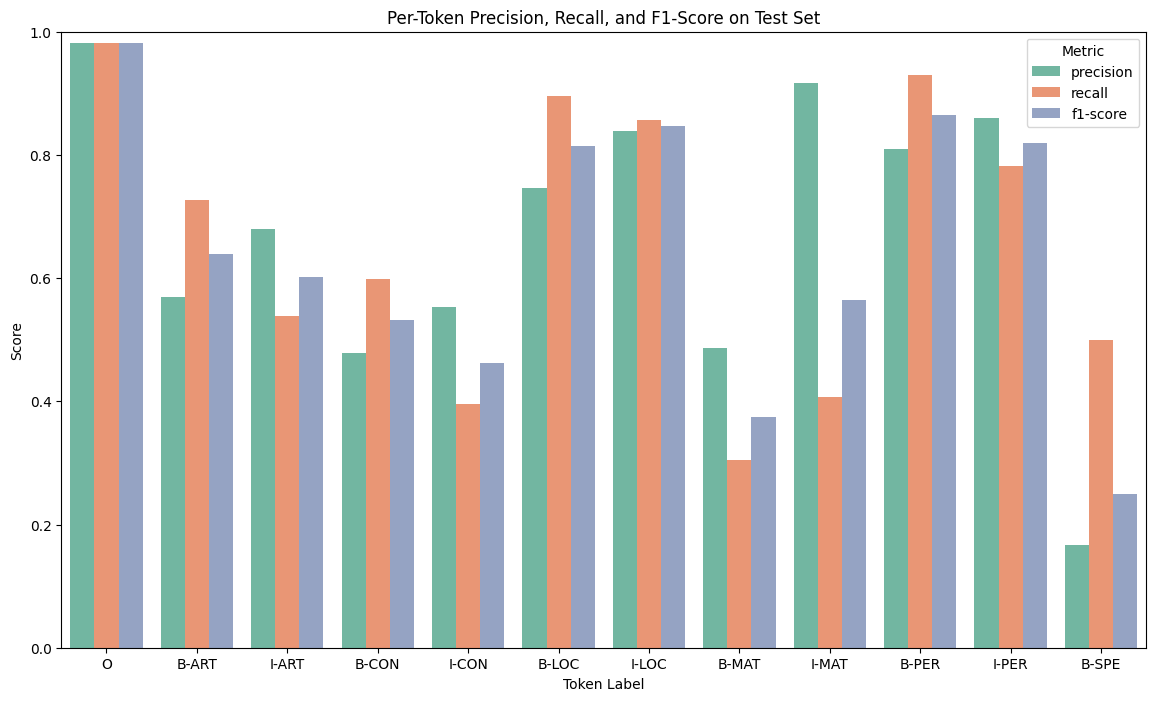

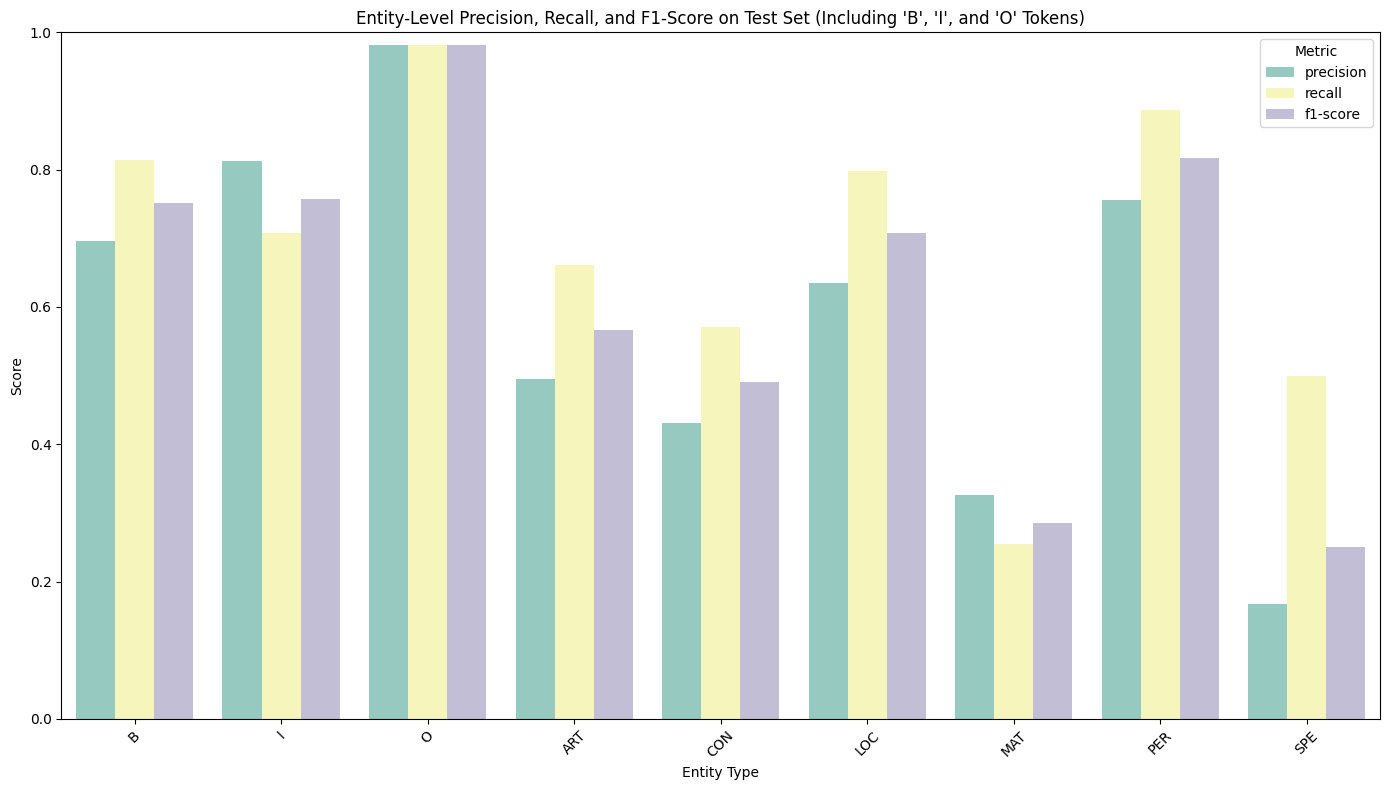

In [108]:

%matplotlib inline

token_metrics = {label: metrics for label, metrics in token_report.items()
                 if label not in ['micro avg', 'macro avg', 'weighted avg', 'accuracy']}

token_df = pd.DataFrame(token_metrics).T.reset_index().rename(columns={'index': 'Label'})
token_df = token_df[['Label', 'precision', 'recall', 'f1-score', 'support']]

token_melted = token_df.melt(
    id_vars=['Label', 'support'],
    value_vars=['precision', 'recall', 'f1-score'],
    var_name='Metric',
    value_name='Score'
)

entity_metrics = {label: metrics for label, metrics in entity_report.items()
                  if label not in ['micro avg', 'macro avg', 'weighted avg']}

entity_df = pd.DataFrame(entity_metrics).T.reset_index().rename(columns={'index': 'Entity Type'})
entity_df = entity_df[['Entity Type', 'precision', 'recall', 'f1-score', 'support']]

bio_metrics = {label: metrics for label, metrics in token_report_bio.items() if label in ['B', 'I', 'O']}

bio_df = pd.DataFrame(bio_metrics).T.reset_index().rename(columns={'index': 'Entity Type'})
bio_df = bio_df[['Entity Type', 'precision', 'recall', 'f1-score', 'support']]

# Combine 'B', 'I', and 'O' metrics with Entity-Level Metrics
entity_df_combined = pd.concat([entity_df, bio_df], ignore_index=True)


entity_melted_combined = entity_df_combined.melt(
    id_vars=['Entity Type', 'support'],
    value_vars=['precision', 'recall', 'f1-score'],
    var_name='Metric',
    value_name='Score'
)

# Order 'B', 'I', O'

other_entities = sorted([
    et for et in entity_df_combined['Entity Type'].unique()
    if et not in ['B', 'I', 'O']
])
desired_order = ['B', 'I', 'O'] + other_entities

entity_melted_combined['Entity Type'] = pd.Categorical(
    entity_melted_combined['Entity Type'],
    categories=desired_order,
    ordered=True
)

# %%
# Plot 1: Per-Token Metrics
plt.figure(figsize=(14, 8))
sns.barplot(
    x='Label',
    y='Score',
    hue='Metric',
    data=token_melted,
    palette='Set2'
)
plt.title('Per-Token Precision, Recall, and F1-Score on Test Set')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.xlabel('Token Label')
plt.legend(title='Metric')
plt.show()

# %%
# Plot 2: Entity-Level Metrics including 'B', 'I', and 'O'
plt.figure(figsize=(14, 8))
sns.barplot(
    x='Entity Type',
    y='Score',
    hue='Metric',
    data=entity_melted_combined,
    palette='Set3'
)
plt.title('Entity-Level Precision, Recall, and F1-Score on Test Set (Including \'B\', \'I\', and \'O\' Tokens)')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.xlabel('Entity Type')
plt.legend(title='Metric')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
